In [13]:
import psycopg2
import sys
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import time , datetime , date
plt.rcParams['figure.figsize'] = (15, 10)

In [2]:

conn_string = "host='localhost' dbname='gtrader' user='postgres' password='postgres'"
print "Connecting to database\n	->%s" % (conn_string)
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
print "Connected!\n"

Connecting to database
	->host='localhost' dbname='gtrader' user='postgres' password='postgres'
Connected!



In [3]:
df1 = pd.read_sql("select * from nymex_future_cl_201712 order by event_date desc",conn)

In [4]:
print len(df1)

688547


In [7]:
df2 = df1.copy()
df2['datetime'] = df2.apply(lambda x : datetime.combine( x['event_date'] , x['event_time'] ) , axis = 1)
df2['event_time'] = df2['event_time'].apply(lambda x : time.strftime(x , '%H:%M:%S.%f'))
df2['event_date'] = df2['event_date'].apply(lambda x : date.strftime(x , '%Y-%m-%d'))
df2 = df2.set_index(['datetime'])

In [9]:
trades = df2[df2['event_type'] == 'TRADE']

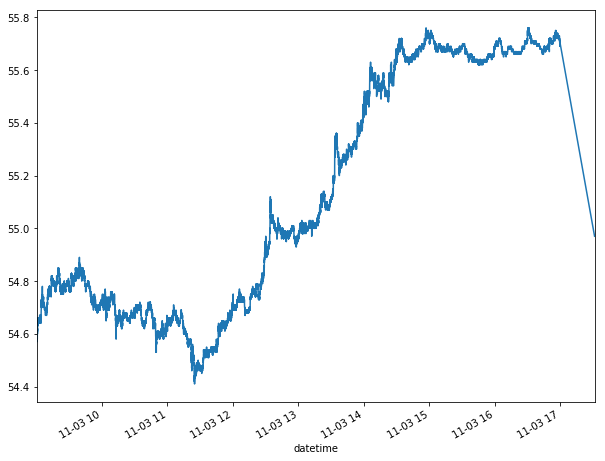

,event_date,event_time,event_type,event_price,event_size,ask_price,ask_size,bid_price,bid_size,label
datetime,,,,,,,,,,
2017-11-03 09:36:50.397,2017-11-03,09:36:50.397000,TRADE,54.81,10,54.82,70,54.81,70,None
2017-11-03 09:36:50.699,2017-11-03,09:36:50.699000,TRADE,54.82,1,54.82,67,54.81,49,None
2017-11-03 09:36:51.300,2017-11-03,09:36:51.300000,TRADE,54.82,6,54.82,52,54.81,72,None
2017-11-03 09:36:51.401,2017-11-03,09:36:51.401000,TRADE,54.82,13,54.82,31,54.81,109,None
2017-11-03 09:36:52.606,2017-11-03,09:36:52.606000,TRADE,54.82,2,54.83,88,54.82,47,None


In [17]:
trades_day_11_03 = trades[ trades['event_date'] == '2017-11-03' ]
trades_in_interval_1 = trades_day_11_03[ (trades_day_11_03['event_time'] >= '09:00:00') & (trades_day_11_03['event_time'] <= '18:00:00')]
trades_in_interval_1['event_price'].plot()
plt.show()
trades_in_interval_1.head()



In [23]:
def sum_prev_feature(windowSize):
    return 'sum_prev_'+ str(windowSize)

def sum_next_feature(windowSize):
    return 'sum_next_'+ str(windowSize)

def get_frame_with_avg_front_and_back(frame , feature , windowSize):

    all_previous = []
    all_nexts = []
    for i in range(0,len(frame)):
        
        previousSum = None
        if i >= windowSize :
            previous = [frame[feature].values[x] for x in range(i - windowSize,i)]
            previousSum = reduce(lambda x,y : x+y , previous)
        else:
            previousSum = "NaN"
            
        nextSum = None
        if i < len(frame) - windowSize:
            nexts = [frame[feature].values[x] for x in range(i,i+windowSize)]
            nextSum = reduce(lambda x,y : x+y , nexts)
        else:
            nextSum = "NaN"
        
        all_previous.append(previousSum)
        all_nexts.append(nextSum)
    
    dsx = frame.copy()
    dsx[sum_next_feature(windowSize)] = all_nexts
    dsx[sum_prev_feature(windowSize)] = all_previous
    
    return dsx

def get_frame_with_trend_ratio(frame , feature , windowSize ):
    dsx = get_frame_with_avg_front_and_back(frame , feature , windowSize)
    dsx = dsx[ (dsx[sum_next_feature(windowSize)] != "NaN") & (dsx[sum_prev_feature(windowSize)] != "NaN") ]
    dsx['ratio'] = dsx[sum_next_feature(windowSize)] / dsx[sum_prev_feature(windowSize)]
    dsx['slope_1'] = dsx['ratio'].apply(lambda x : np.log(x))
    dsx['slope_2'] = dsx[sum_next_feature(windowSize)] - dsx[sum_prev_feature(windowSize)]
    return dsx

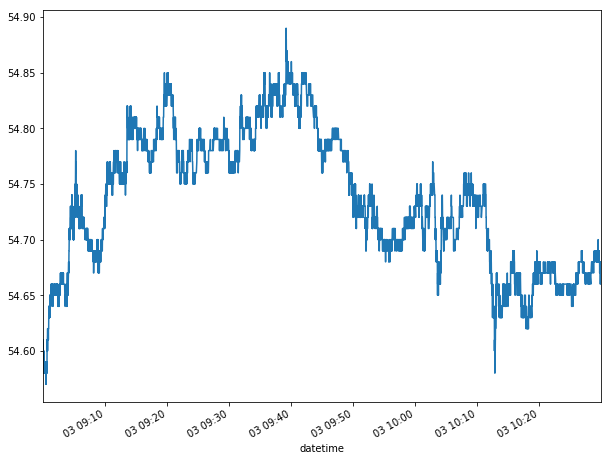

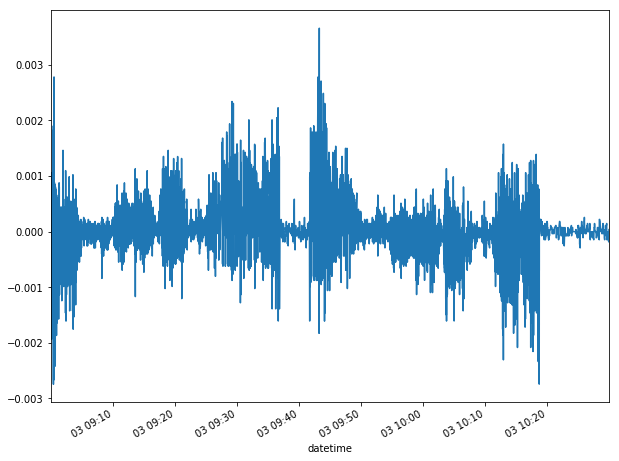

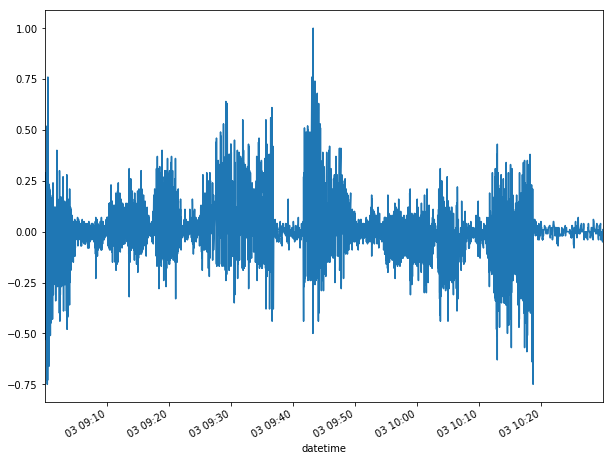

In [24]:
sample = trades_in_interval_1

ratio_set = get_frame_with_trend_ratio(sample , 'event_price' , 5)
plt.rcParams['figure.figsize'] = (10, 8)
sample['event_price'].plot()
plt.show()
ratio_set['slope_1'].plot()
plt.show()
ratio_set['slope_2'].plot()
plt.show()

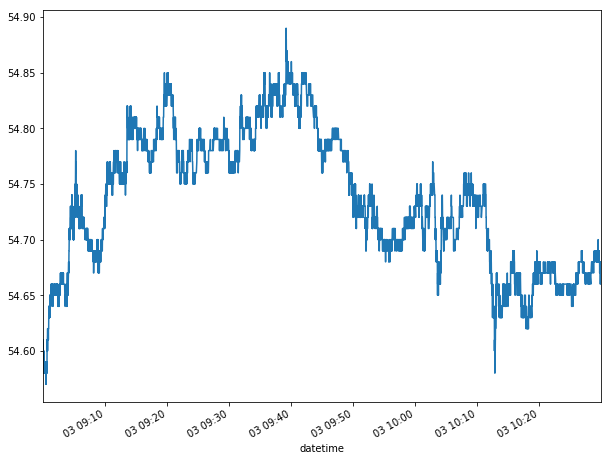

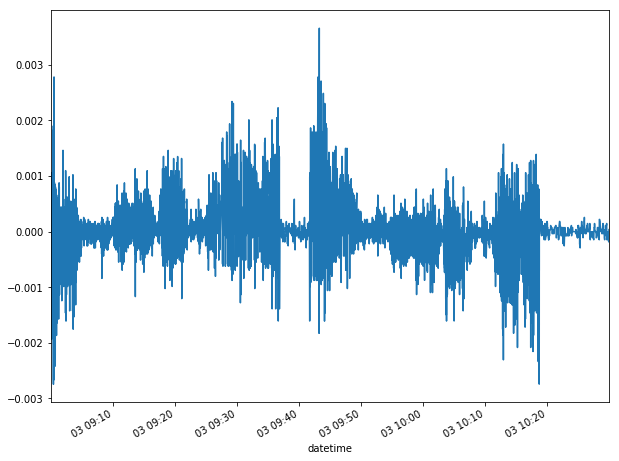

In [20]:
trades_in_interval_1 = trades_day_11_03[ (trades_day_11_03['event_time'] >= '09:00:00') & (trades_day_11_03['event_time'] <= '10:30:00')]
sample = trades_in_interval_1
ratio_set = get_frame_with_trend_ratio(sample , 'event_price' , 5)
plt.rcParams['figure.figsize'] = (10, 8)
sample['event_price'].plot()
plt.show()
ratio_set['slope_1'].plot()
plt.show()